In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Reading the Weather and PM2.5 Data

- using min-max normalization

In [7]:
from data_preprocessing import load_X_y
import pandas as pd

weather_df, pollutant_df = load_X_y()

In [8]:
weather_df_normalized = (weather_df-weather_df.min())/(weather_df.max()-weather_df.min())
weather_df_normalized.describe()

,max_dew_point_v,max_relative_humidity_v,max_temperature_v,max_wind_speed_v,min_dew_point_v,min_relative_humidity_v,min_temperature_v,min_wind_speed_v,precipitation_v,rain_v,snow_v,snow_on_ground_v
count,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000,7304.000000
mean,0.514953,0.571856,0.524171,0.571205,0.518990,0.486371,0.519177,0.510449,0.491174,0.509921,0.247726,0.177910
std,0.335249,0.218783,0.335174,0.255798,0.326785,0.261585,0.314073,0.271372,0.181621,0.244698,0.315199,0.278788
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.179659,0.412934,0.182859,0.357715,0.201610,0.258465,0.210211,0.271762,0.344340,0.237410,0.000000,0.000000
50%,0.495475,0.597683,0.536310,0.632265,0.500370,0.435290,0.517430,0.509554,0.504717,0.593525,0.016667,0.000000
75%,0.863534,0.743629,0.859094,0.795591,0.851591,0.731753,0.828169,0.762208,0.617925,0.701439,0.583333,0.360465
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [9]:
pollutant_df.describe()

,P2.5
count,7304.000000
mean,7.435753
std,5.374638
min,0.000000
25%,3.916667
50%,6.166667
75%,9.333333
max,58.666667


In [10]:
pollutant_tensor = torch.tensor(pollutant_df['P2.5'].values)
weather_tensor = torch.tensor(weather_df_normalized[:].values)

print(pollutant_tensor.shape)
print(weather_tensor.shape)

torch.Size([7304])
torch.Size([7304, 12])


In [11]:
type(pollutant_tensor)

torch.Tensor

# Dataset

- We'll train using the first 5000+14 days to train, 1000+14 days to validate, 1000+14 days to test
- Ensure sequencing is maintained
- Test data will be the latest data as the model is intended to use historical data to predict future data

In [12]:
from torch.utils.data import Dataset

In [13]:
# creating a custom dataset in a sliding window manner
class WeatherPollutantDataset(Dataset):
    def __init__(self, weather: torch.Tensor, pollutant: torch.Tensor, window:int):
        self.weather = weather
        self.pollutant = pollutant
        # assumes the data starts on the same day
        # assumes their length is the same
        assert len(self.weather) == len(self.pollutant)
        self.window = window

    def __getitem__(self, index: int):
        """
        Using weather input on day i,i+1,...,i+window-1 to predict pollutant output on i+window
        """
        weather_input = self.weather[index:index+self.window].permute(1,0)
        pollutant_output = self.pollutant[index+1:index+self.window+1]
        return weather_input, pollutant_output

    def __len__(self):
        return len(self.weather) - self.window

In [14]:
train_set = WeatherPollutantDataset(weather=weather_tensor[:5014], pollutant=pollutant_tensor[:5014], window=14)
val_set   = WeatherPollutantDataset(weather=weather_tensor[5014:6028], pollutant=pollutant_tensor[5014:6028], window=14)
test_set  = WeatherPollutantDataset(weather=weather_tensor[6028:7042], pollutant=pollutant_tensor[6028:7042], window=14)

In [15]:
print("Number of training data: %d" % len(train_set))
print("Number of validation data: %d" % len(val_set))
print("Number of testing data: %d" % len(test_set))

Number of training data: 5000
Number of validation data: 1000
Number of testing data: 1000


In [16]:
from torch.utils.data import DataLoader

In [17]:
test_loader = DataLoader(test_set, batch_size=64)
next(iter(test_loader))[0].shape

torch.Size([64, 12, 14])

# Model

In [58]:
class CNNLSTMParam(nn.Module):
    def __init__(self, in1, out1, out2, out3, hidden_size_lstm, num_layers_lstm, dense_neurons):
        super().__init__()
        self.name = "CNNLSTM"
        self.out3 = out3
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv1 = nn.Conv1d(in_channels=12, out_channels=out1, kernel_size=3, stride=1, padding=1)
   
        self.norm1 = nn.BatchNorm1d(num_features = out1)
        self.conv2 = nn.Conv1d(in_channels=out1, out_channels=out2, kernel_size=3, stride=1, padding=1)
        self.norm2 = nn.BatchNorm1d(num_features = out2)
        self.conv3 = nn.Conv1d(in_channels=out2, out_channels=out3, kernel_size=3, stride=1, padding=1)
        self.norm3 = nn.BatchNorm1d(num_features = out3)

        self.lstm = nn.LSTM(input_size=7*out3, hidden_size=hidden_size_lstm, num_layers=num_layers_lstm, batch_first=True)
        self.linear1 = nn.Linear(hidden_size_lstm, dense_neurons)
        self.linear2 = nn.Linear(dense_neurons, 14)

    def forward(self, x):
     
        x = F.relu(self.norm1(self.conv1(x)))
        x = F.relu(self.norm2(self.conv2(x)))
        x = F.relu(self.norm3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 7*self.out3)
        # x = x.squeeze(dim=2)
        x, _ = self.lstm(x)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [59]:
import matplotlib.pyplot as plt
def evaluate(net, loader, criterion):
    total_loss = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        # if torch.cuda.is_available():
        inputs = inputs.float()
        labels = labels.float()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        total_epoch += len(labels)
    loss = float(total_loss) / (i + 1)
    
    
    return loss

def train_net(hyperparameters):
    torch.manual_seed(1000)
    
    batch_size, learning_rate, num_epochs, in1, out1, out2, out3, hidden_size_lstm, num_layers_lstm, dense_neurons = hyperparameters
    
    net = CNNLSTMParam(in1, out1, out2, out3, hidden_size_lstm, num_layers_lstm, dense_neurons) 
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle=False)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle=False)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate)

    train_loss = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    
    
    net.train()
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_epoch = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            # if torch.torch.cuda.is_available():
            inputs = inputs.float()
            labels = labels.float()
            optimizer.zero_grad()
            outputs = net(inputs).squeeze()
            labels = labels.squeeze()
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            # Calculate the statistics
            total_train_loss += loss.item()
            # total_epoch += len(labels)
            total_epoch += 1
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_loss[epoch] = evaluate(net, val_loader, criterion)
        if epoch%10 == 0:
            print(("Epoch {}: Train loss: {} | Validation loss: {}").format(epoch,train_loss[epoch],val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        # torch.save(net.state_dict(), 'ckpt/01112023_mse_batchsize_%d_learningrate_%d_epoch_%d'%(batch_size, learning_rate, 60+epoch))
    net.eval()
    print('Finished Training')
    
    with open('ga_runs.txt', 'a') as f:
        print('Writing to file')
        f.write(str(hyperparameters))
        f.write('\t')
        f.write(str(train_loss[-1]))
        f.write('\t')
        f.write(str(val_loss[-1]))
        f.write('\n')
     
    
    return (train_loss[-1]+2*val_loss[-1])/3, net
    # Write the train/test loss/err into CSV file for plotting later
    # epochs = np.arange(1, num_epochs + 1)
    # plt.title("Train loss")
    # plt.plot(epochs, train_loss)
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")

    # plt.title("Validation loss")
    # plt.plot(epochs, val_loss)
    # plt.xlabel("Epoch")
    # plt.ylabel("Loss")



In [60]:
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli

import numpy as np
from bitstring import BitArray


def train_evaluate(ga_individual_solution):
    gene_length = 8
    num_epochs = 30
    

    in1 = BitArray(ga_individual_solution[0:gene_length])
    out1 = BitArray(ga_individual_solution[gene_length:2*gene_length])
    out2 = BitArray(ga_individual_solution[2*gene_length:3*gene_length])
    out3 = BitArray(ga_individual_solution[3*gene_length:4*gene_length])
    hidden_size_lstm = BitArray(ga_individual_solution[4*gene_length:5*gene_length])
    num_layers_lstm = BitArray(ga_individual_solution[5*gene_length:6*gene_length])
    dense_neurons = BitArray(ga_individual_solution[6*gene_length:7*gene_length])
    lr = BitArray(ga_individual_solution[7*gene_length:8*gene_length])
    batch_size = BitArray(ga_individual_solution[8*gene_length:9*gene_length])
    num_epochs = BitArray(ga_individual_solution[9*gene_length:10*gene_length])

    in1 = in1.uint
    out1 = out1.uint
    out2 = out2.uint
    out3 = out3.uint
    hidden_size_lstm = hidden_size_lstm.uint
    num_layers_lstm = num_layers_lstm.uint
    dense_neurons = dense_neurons.uint
  
    lr = lr.uint
    batch_size = batch_size.uint
    num_epochs = num_epochs.uint

    # resize hyperparameterss to be within range
    in1 = int(np.interp(in1, [0, 255], [1, 31]))
    out1 = int(np.interp(out1, [0, 255], [4, 100]))
    out2 = int(np.interp(out2, [0, 255], [4, 100]))
    out3 = int(np.interp(out3, [0, 255], [4, 100]))
    hidden_size_lstm = int(np.interp(hidden_size_lstm, [0, 255], [2, 25]))
    num_layers_lstm = int(np.interp(num_layers_lstm, [0, 255], [1, 5]))
    dense_neurons = int(np.interp(dense_neurons, [0, 255], [10, 50]))
    lr = np.interp(lr, [0, 255], [0.0005, 0.2])
    batch_size = int(np.interp(batch_size, [0, 255], [1, 64]))
    num_epochs = int(np.interp(num_epochs, [0, 255], [10, 100]))
    num_layers_lstm = 1
    #to optimise: seq, num_layers_conv, output_channels (num of kernels), hidden_size_lstm, num_layers_lstm, lr, batch_size, n_epoch
    hyperparameters = [batch_size, lr, num_epochs, in1, out1, out2, out3, hidden_size_lstm, num_layers_lstm, dense_neurons]
    #[26, 4, [13, 18, 7, 1], [3, 3, 3, 3], [1, 1, 1, 1], [1, 1, 1, 1], 4, 1, None, 0.04515, 1833, 100]
    print(f'hyperparameters: {hyperparameters}')
    loss = train_net(hyperparameters)
    return [loss]


population_size = 50
num_generations = 5
entire_bit_array_length = 11*8

creator.create('FitnessMax', base.Fitness, weights=[-1.0])
creator.create('Individual', list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=entire_bit_array_length)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.6)
toolbox.register('select', tools.selTournament, tournsize=int(population_size/2))
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n=population_size)
r = algorithms.eaSimple(population, toolbox, cxpb=0.4, mutpb=0.1, ngen=num_generations, verbose=True)

best_individual = tools.selBest(population, k=1)[0]
print('Best ever individual = ', best_individual, '\nFitness = ', best_individual.fitness.values[0])
print(f'list of individuals = {best_individual}')



hyperparameters: [18, 0.09907647058823531, 92, 21, 52, 11, 6, 2, 1, 38]
Epoch 0: Train loss: 24.600440539687657 | Validation loss: 38.85346727286066


KeyboardInterrupt: 

In [61]:
_, net = train_net([59, 0.06230588235294118, 78, 16, 39, 48, 80, 21, 1, 11])

Epoch 0: Train loss: 30.322505995806527 | Validation loss: 40.23474931716919
Epoch 10: Train loss: 21.828172492980958 | Validation loss: 37.52723623724545
Epoch 20: Train loss: 21.30751817927641 | Validation loss: 35.7322930728688
Epoch 30: Train loss: 20.628741774839515 | Validation loss: 34.94048376644359
Epoch 40: Train loss: 20.042576705708225 | Validation loss: 34.49970377192778
Epoch 50: Train loss: 19.30090917699477 | Validation loss: 33.99808109507841
Epoch 60: Train loss: 20.03396426930147 | Validation loss: 35.87345510370591
Epoch 70: Train loss: 18.95833729575662 | Validation loss: 35.327150485094855
Finished Training
Writing to file


53.4475207114128


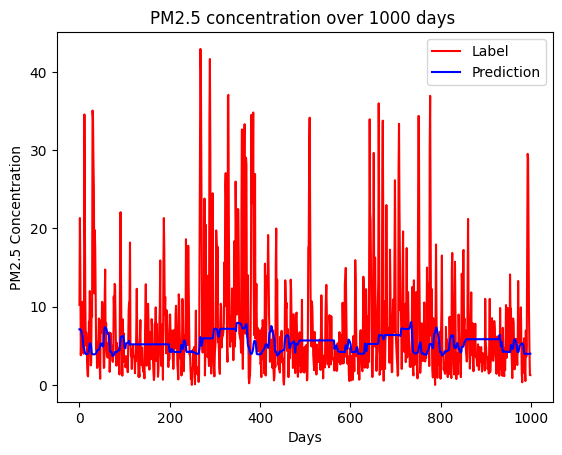

In [62]:
test_loader = DataLoader(test_set, batch_size=len(test_set), shuffle=False)
data, label = next(iter(test_loader))
data = data.float()
pred = net(data)

mse = nn.MSELoss()
loss = mse(pred, label)
print(loss.item())


t = range(1000)
plt.title("PM2.5 concentration over 1000 days ")
plt.plot(t, label.transpose(0,1)[0], 'r', label="Label")
plt.plot(t, pred.cpu().detach().numpy().transpose(0,1)[:,0], 'b', label='Prediction')
plt.xlabel("Days")
plt.ylabel("PM2.5 Concentration")
plt.legend(loc='best')
plt.show()